# Builds for Gypsy mod

Developed for gypsy 1.36.1

In [1]:

import random
import itertools
from math import comb
import numpy as np
from collections import Counter, defaultdict

import yaml
from functools import lru_cache

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

## Load data

In [3]:
IDEAS_PATHS = [
    '../data/processed/gypsy-1-36-1/00_basic_ideas.yaml', 
    '../data/processed/gypsy-1-36-1/00_flogi_ideas.yaml', 
]

class Idea():
    def __init__(self, name:str, type: str, effect: dict):
        self.name = name
        self.type = type
        self.effect = effect

    def __repr__(self):
        return f'Idea({self.name}, {self.type}, {self.effect})'

IDEAS = {}
IDEA_PROTECTED_KEYS = ['category']
for path in IDEAS_PATHS:
    with open(path, 'r') as f:
        ideas_dict = yaml.load(f, Loader=yaml.FullLoader)
    for name, value in ideas_dict.items():
        category = value['category']
        effect = Counter()
        for key in value.keys():
            if key not in IDEA_PROTECTED_KEYS:
                effect_set = value[key]
                for k, v in effect_set.items():
                    effect[k] += abs(v)
        IDEAS[name] = Idea(name=name, type=category, effect=effect)


In [4]:
# IDEAS

In [5]:
POLICIES_PATHS = [
    '../data/processed/gypsy-1-36-1/Idea_Variation_policies.yaml'
]

class Policy():
    def __init__(self, name:str, type: str, req: tuple, effect: dict):
        self.name = name
        self.type = type
        self.req = req
        self.effect = effect

    def __repr__(self):
        return f"Policy({self.name}, {self.type}, {self.req}, {self.effect})"

POLICIES = []
POLICY_PROTECTED_KEYS = ['monarch_power', 'req']
for path in POLICIES_PATHS:
    with open(path, 'r') as f:
        policies_dict = yaml.load(f, Loader=yaml.FullLoader)
    for name, value in policies_dict.items():
        monarch_power = value['monarch_power']
        req0, req1 = value['req']
        effect = Counter()
        for key in value.keys():
            if key not in POLICY_PROTECTED_KEYS:
                effect[key] = abs(value[key])
        POLICIES.append(Policy(
                name = name, 
                type = value['monarch_power'], 
                req = (req0, req1),
                effect = effect
            ))


In [6]:
class Build():
    def __init__(self, 
                 ideas: tuple[str], 
                 score: float, 
                 total_effect: Counter, 
                 war_policies_effect: dict
    ):
        self.ideas = ideas
        self.score = score
        self.total_effect = total_effect
        self.war_policies_effect = war_policies_effect

    def __repr__(self):
        return f"Build( {self.score:.2f} - ideas: {self.ideas})"
    
def print_build(build: Build, effects: list[str]):
    print('--------------------------------------------------------------------')
    print(f"Build - score: {build.score} - ideas: {build.ideas}")
    for effect in effects:
        print(f"\t{effect}: {build.total_effect[effect]:.2f}")

## Build ideas

In [7]:
adm_idea_names = [v.name for k, v in IDEAS.items() if v.type == 'ADM']
dip_idea_names = [v.name for k, v in IDEAS.items() if v.type == 'DIP']
mil_idea_names = [v.name for k, v in IDEAS.items() if v.type == 'MIL']

In [8]:
adm_idea_names

['administrative_ideas',
 'economic_ideas',
 'expansion_ideas',
 'humanist_ideas',
 'infrastructure_ideas',
 'innovativeness_ideas',
 'religious_ideas',
 'anglican0',
 'animist0',
 'buddhism0',
 'cathar0',
 'catholic0',
 'centralisation0',
 'confucian0',
 'coptic0',
 'decentralisation0',
 'development0',
 'dictatorship0',
 'dreamtime0',
 'fetishist0',
 'hellenic0',
 'hindu0',
 'horde0',
 'hussite0',
 'ibadi0',
 'inti0',
 'jewish0',
 'jurisprudence0',
 'manichean0',
 'mesoamerican0',
 'monarchy0',
 'nahuatl0',
 'norse0',
 'orthodox0',
 'protestant0',
 'reformed0',
 'republic0',
 'romuva0',
 'shia0',
 'shinto0',
 'slavic0',
 'state_administration0',
 'strongfem0',
 'strongman0',
 'sunni0',
 'suomi0',
 'tengri0',
 'theocracy0',
 'totemist0',
 'zoroastrian0']

In [9]:
adm_idea_names = [
    'administrative_ideas',
    'economic_ideas',
    'expansion_ideas',
    'humanist_ideas',
    # 'infrastructure_ideas', Not allowed in mod
    'innovativeness_ideas',
    'centralisation0',
    'decentralisation0',
    'development0',
    'jurisprudence0',
    'state_administration0',
    # 'strongfem0', Same as strongman0
    'strongman0',
]
# Uncomment one of the following lines to allow the corresponding religious idea group
rel_idea_names = [
    # 'religious_ideas',
    # 'anglican0',
    # 'animist0',
    # 'buddhism0',
    # 'cathar0',
    'catholic0',
    # 'confucian0',
    # 'coptic0',
    # 'dreamtime0',
    # 'fetishist0',
    # 'hellenic0',
    # 'hindu0',
    # 'hussite0',
    # 'ibadi0',
    # 'inti0',
    # 'jewish0',
    # 'manichean0',
    # 'mesoamerican0',
    # 'nahuatl0',
    # 'norse0',
    # 'orthodox0',
    # 'protestant0',
    # 'reformed0',
    # 'romuva0',
    # 'shia0',
    # 'shinto0',
    # 'slavic0',
    # 'sunni0',
    # 'suomi0',
    # 'tengri0',
    # 'totemist0',
    # 'zoroastrian0'
]
# Uncomment one of the following lines to allow the corresponding government idea group
gov_idea_names = [
    # 'dictatorship0',
    # 'horde0',
    'monarchy0',
    # 'republic0',
    # 'theocracy0',
]
adm_not_compatible = [
    ('strongfem0', 'strongman0',),
    ('centralisation0', 'decentralisation0',),
]
adm_idea_scope = adm_idea_names + rel_idea_names + gov_idea_names

In [10]:
dip_idea_names

['court_ideas',
 'dynasty0',
 'exploration_ideas',
 'influence_ideas',
 'maritime_ideas',
 'spy_ideas',
 'trade_ideas',
 'assimilation0',
 'colonial_empire0',
 'fleet_base0',
 'galley0',
 'heavy_ship0',
 'imperial_ambition0',
 'imperialism0',
 'light_ship0',
 'nationalism0',
 'propaganda0',
 'society0']

In [11]:
dip_idea_names = [
    # 'court_ideas', Not allowed in mod
    'dynasty0',
    'exploration_ideas',
    'influence_ideas',
    'maritime_ideas',
    'spy_ideas',
    'trade_ideas',
    'assimilation0',
    'colonial_empire0',
    'fleet_base0',
    'galley0',
    'heavy_ship0',
    'light_ship0',
    'nationalism0',
    'propaganda0',
    'society0'
]
imp_idea_names = [
    'imperial_ambition0',
    # 'imperialism0',
]
dip_not_compatible = [
    ('galley0', 'heavy_ship0'),
    ('galley0', 'light_ship0'),
    ('heavy_ship0', 'light_ship0'),
]
dip_idea_scope = dip_idea_names + imp_idea_names

In [12]:
mil_idea_names

['aristocracy_ideas',
 'defensive0',
 'horde_gov_ideas',
 'indigenous_ideas',
 'mercenary_ideas',
 'naval_ideas',
 'offensive0',
 'plutocracy_ideas',
 'quality0',
 'quantity0',
 'theocracy_gov_ideas',
 'conscription0',
 'fire0',
 'fortress0',
 'general_staff0',
 'mercenary0',
 'militarism0',
 'shock0',
 'standing_army0',
 'tactical0',
 'war_production0',
 'weapon_quality0']

In [13]:
mil_idea_names = [
    # 'aristocracy_ideas',
    # 'horde_gov_ideas',
    # 'indigenous_ideas',
    # 'theocracy_gov_ideas',
    # 'plutocracy_ideas',
    # 'mercenary_ideas',
    # 'naval_ideas',
    'offensive0',
    'defensive0',
    'quality0',
    'quantity0',
    'general_staff0',
    'standing_army0',
    'conscription0',
    'mercenary0',
    'weapon_quality0',
    'fortress0',
    'war_production0',
    'tactical0',
    'militarism0',
    'fire0',
    'shock0',
]
mil_not_compatible = [
    ('offensive0', 'defensive0'),
    ('quality0', 'quantity0'),
    ('standing_army0', 'conscription0'),
    ('fire0', 'shock0')
]
mil_idea_scope = mil_idea_names

In [14]:
all_ideas = adm_idea_scope + dip_idea_scope + mil_idea_scope

## Build score

In [15]:
extra_idea_score = {
    'nationalism0': 50 # Estate interaction - main +1 ADM and +1 DIP
}

In [16]:
# Print all possible effects of all ideas and policies and the max value of each effect
all_effects = set()
for idea in IDEAS.values():
    all_effects.update(idea.effect.keys())
for policy in POLICIES:
    all_effects.update(policy.effect.keys())
all_effects = sorted(list(all_effects))
for effect in all_effects:
    max_value = max([abs(idea.effect[effect]) for idea in IDEAS.values()])
    print(f"{effect}: {max_value:.2f}")

accept_vassalization_reasons: 15.00
adm_tech_cost_modifier: 0.10
admiral_cost: 0.50
advisor_cost: 0.20
advisor_pool: 1.00
ae_impact: 0.15
all_estate_loyalty_equilibrium: 0.10
all_estate_possible_privileges: 1.00
allow_mercenary_drill: 1.00
allowed_marine_fraction: 0.25
army_tradition: 1.00
army_tradition_decay: 0.01
artillery_cost: 0.15
artillery_levels_available_vs_fort: 1.00
artillery_power: 0.15
autonomy_change_time: 0.50
backrow_artillery_damage: 0.10
blockade_efficiency: 0.50
brahmins_hindu_loyalty_modifier: 0.10
brahmins_muslim_loyalty_modifier: 0.10
build_cost: 0.25
build_time: 0.33
burghers_loyalty_modifier: 0.10
can_fabricate_for_vassals: 1.00
caravan_power: 0.25
cav_to_inf_ratio: 0.30
cavalry_cost: 0.33
cavalry_flanking: 1.00
cavalry_power: 0.25
cb_on_overseas: 1.00
cb_on_primitives: 1.00
cb_on_religious_enemies: 1.00
center_of_trade_upgrade_cost: 0.20
church_loyalty_modifier: 0.10
church_power_modifier: 0.75
claim_duration: 0.25
colonist_placement_chance: 0.15
colonists: 2.0

In [17]:
# Country weights are used to determine the score of a country during peace time
COUNTRY_WEIGHTS = {
    # Development
    'development_cost': 150,                        # Each 10% is 15 points
    'development_cost_in_primary_culture': 100,     # Each 10% is 10 points
    # Mana
    'country_admin_power': 25,                      # Each point is 100 points
    'country_diplomatic_power': 25,                 # Each point is 100 points
    # Policies
    'free_policy': 5,                               # Each free extra policy is 5 points
    'free_adm_policy': 2,                           # Each free extra policy is 2 points
    'free_dip_policy': 2,                           # Each free extra policy is 2 points
    'free_mil_policy': 1,                           # Each free extra policy is 1 points
    'possible_policy': 12,                          # Each extra policy column is 12 points
    'possible_adm_policy': 4,                       # Each possible policy is 4 points
    'possible_dip_policy':  4,                      # Each possible policy is 4 points
    'possible_mil_policy': 4,                       # Each possible policy is 4 points
    # Tech and idea cost        
    'technology_cost': 60,                           # Each 10% discount is 6 points
    'adm_tech_cost_modifier': 20,                    # Each 10% discount is 2 point
    'dip_tech_cost_modifier':  20,                   # Each 10% discount is 2 point
    'mil_tech_cost_modifier':  20,                   # Each 10% discount is 2 point
    'idea_cost': 60,                                 # Each 10% discount is 6 points
    # State     
    'governing_capacity_modifier': 30,              # Each 10% is 3 points
    'advisor_cost': 10,                             # Each 10% discount is 1 point
    'monthly_reform_progress_modifier': 20,         # Each 10% is 2 point
    'monthly_reform_progress': 10,                  # Each point is 10 point
    'reform_progress_growth': 20,                   # Each 10% is 2 point
    # Economy       
    'global_tax_modifier': 5,                       # Each 10% is 0.5 point
    'production_efficiency': 5,                     # Each 10% is 0.5 point
    'global_trade_goods_size_modifier': 5,          # Each 10% is 0.5 point
    'trade_efficiency': 5,                          # Each 10% is 0.5 point
    # Buildings     
    'build_cost': 20,                               # Each 10% discount is 2 points
}

# War weights are used to determine the score of a country during war time and to find the best policies
MILITARY_WEIGHTS ={
    # Main modifiers
    'discipline': 300,                              # Each 10% is 30 points
    'fire_damage': 150,                             # Each 10% is 15 points
    'fire_damage_received': 150,                    # Each 10% is 15 points
    'shock_damage': 150,                            # Each 10% is 15 points
    'shock_damage_received': 150,                   # Each 10% is 15 points
    'land_morale': 150,                             # Each 10% is 15 points
    'army_tradition': 10,                           # Each 10% is 1 points
    # Infantry  
    'infantry_power': 150,                          # Each 10% is 15 points
    'infantry_cost': 10,                            # Each 10% discount is 1 points
    # Cavalry   
    'cavalry_power': 150,                           # Each 10% is 15 points
    'cavalry_flanking': 10,                         # Each point is 10 points
    # Artillery 
    'artillery_power': 150,                         # Each 10% is 15 points
    'backrow_artillery_damage': 100,                # Each 10% is 10 points
    # Army  
    'global_manpower_modifier': 50,                 # Each 10% is 5 points
    'land_forcelimit_modifier': 50,                 # Each 10% is 5 points
    'land_maintenance_modifier': 20,                # Each 10% discount is 2 points
    'manpower_recovery_speed': 20,                  # Each 10% is 2 points
    'manpower_in_true_faith_provinces': 20,         # Each 10% is 2 points
    # Defensiveness
    'defensiveness': 10,                            # Each 10% is 1 points
    'fort_maintenance_modifier': 5,                 # Each 10% discount is 0.5 points
    'siege_ability': 5,                             # Each 10% is 0.5 points
}


In [18]:

def score(effects: dict, weights: list[dict], debug=False):
    score = 0
    for weight in weights:
        for key, value in effects.items():
            if key in weight:
                if debug:
                    print(f'{key}: {value} -> {value * weight[key]}')
                score += value * weight[key]
    return score

## Precompute policies for idea couples

In [19]:
POLICY_LIB = {}
for policy in POLICIES:
    req0, req1 = policy.req
    for req0_1 in req0:
        for req1_1 in req1:
            polici_id = sorted([req0_1, req1_1])
            POLICY_LIB[(req0_1, req1_1)] = policy

## Idea potential filter

In [20]:
idea_potential_score = {}
for idea_name in all_ideas:
    idea = IDEAS[idea_name]
    idea_potential_score[idea_name] = score(idea.effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS]) + extra_idea_score.get(idea_name, 0)

Mean: 26.10
Std: 22.85
Min: 0.00
Max: 79.50
Median: 20.62
25%: 6.38
75%: 45.38
90%: 61.03


<Axes: >

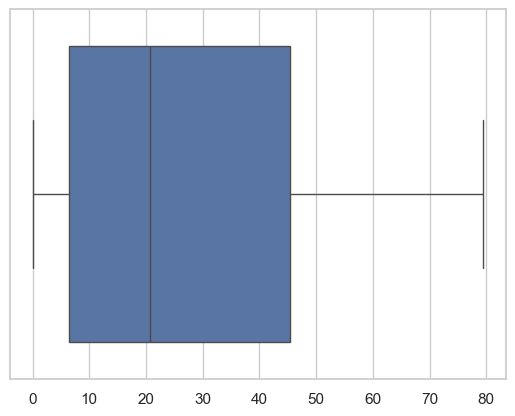

In [21]:
idea_potential_scores = np.array(list(idea_potential_score.values()))
print(f"Mean: {idea_potential_scores.mean():.2f}")
print(f"Std: {idea_potential_scores.std():.2f}")
print(f"Min: {idea_potential_scores.min():.2f}")
print(f"Max: {idea_potential_scores.max():.2f}")
print(f"Median: {np.median(idea_potential_scores):.2f}")
print(f"25%: {np.quantile(idea_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(idea_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(idea_potential_scores, 0.90):.2f}")
sns.boxplot(x=idea_potential_scores)



In [22]:
sorted_ideas = sorted(idea_potential_score.items(), key=lambda x: x[1], reverse=True)
sorted_ideas[:10]

[('conscription0', 79.5),
 ('quality0', 70.0),
 ('defensive0', 64.5),
 ('administrative_ideas', 61.5),
 ('weapon_quality0', 61.25),
 ('standing_army0', 60.5),
 ('quantity0', 60.0),
 ('fire0', 52.25),
 ('shock0', 51.25),
 ('nationalism0', 51.0)]

In [23]:
idea_policies_potential_score = Counter()
for idea_name in all_ideas:
    available_policies = [policy for policy in POLICIES if idea_name in policy.req[0] or idea_name in policy.req[1]]
    for policy in available_policies:
        idea_policies_potential_score[idea_name] += score(policy.effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS])
    

Mean: 129.99
Std: 58.39
Min: 2.00
Max: 244.50
Median: 134.75
25%: 94.94
75%: 174.88
90%: 200.70


<Axes: >

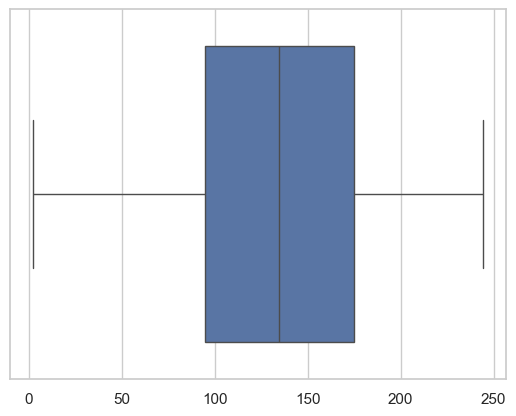

In [24]:
polici_potential_scores = np.array(list(idea_policies_potential_score.values()))
print(f"Mean: {polici_potential_scores.mean():.2f}")
print(f"Std: {polici_potential_scores.std():.2f}")
print(f"Min: {polici_potential_scores.min():.2f}")
print(f"Max: {polici_potential_scores.max():.2f}")
print(f"Median: {np.median(polici_potential_scores):.2f}")
print(f"25%: {np.quantile(polici_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(polici_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(polici_potential_scores, 0.90):.2f}")
sns.boxplot(x=polici_potential_scores)

In [25]:
sorted_ideas = sorted(idea_policies_potential_score.items(), key=lambda x: x[1], reverse=True)
sorted_ideas[:10]

[('conscription0', 244.5),
 ('centralisation0', 211.5),
 ('decentralisation0', 211.5),
 ('tactical0', 203.5),
 ('militarism0', 201.0),
 ('standing_army0', 200.0),
 ('economic_ideas', 192.25),
 ('weapon_quality0', 188.0),
 ('assimilation0', 185.5),
 ('shock0', 183.25)]

Mean: 156.09
Std: 74.62
Min: 2.00
Max: 324.00
Median: 152.57
25%: 112.94
75%: 213.00
90%: 247.05


<Axes: >

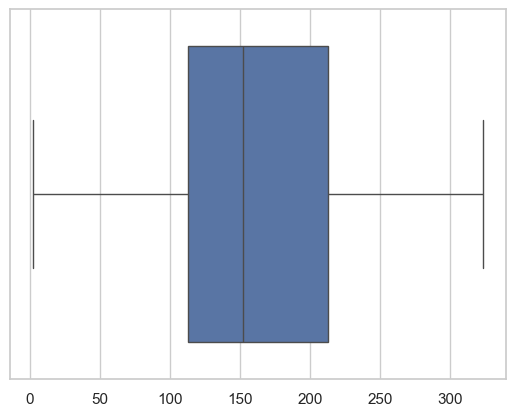

In [26]:
combined_potential_score = {}
for idea_name in all_ideas:
   combined_potential_score[idea_name] = idea_potential_score[idea_name] + idea_policies_potential_score[idea_name]
   
combined_potential_scores = np.array(list(combined_potential_score.values()))
print(f"Mean: {combined_potential_scores.mean():.2f}")
print(f"Std: {combined_potential_scores.std():.2f}")
print(f"Min: {combined_potential_scores.min():.2f}")
print(f"Max: {combined_potential_scores.max():.2f}")
print(f"Median: {np.median(combined_potential_scores):.2f}")
print(f"25%: {np.quantile(combined_potential_scores, 0.25):.2f}")
print(f"75%: {np.quantile(combined_potential_scores, 0.75):.2f}")
print(f"90%: {np.quantile(combined_potential_scores, 0.90):.2f}")
sns.boxplot(x=combined_potential_scores)

In [27]:
sorted_ideas = sorted(combined_potential_score.items(), key=lambda x: x[1], reverse=True)
sorted_ideas[:10]

[('conscription0', 324.0),
 ('standing_army0', 260.5),
 ('decentralisation0', 249.9),
 ('weapon_quality0', 249.25),
 ('quality0', 247.5),
 ('militarism0', 246.0),
 ('defensive0', 238.5),
 ('shock0', 234.5),
 ('tactical0', 227.25),
 ('fire0', 218.25)]

In [28]:
POTENTIAL_CUT_OFF = 0.2

top_ideas = set([k for k, v in combined_potential_score.items() if v > np.quantile(combined_potential_scores, 1-POTENTIAL_CUT_OFF)])

## Support

In [29]:
@lru_cache()
def get_available_policies(ideas: tuple[str]):
    policy_pool = []
    for policy in POLICIES:
       for idea_A, idea_B in itertools.combinations(ideas, 2):
            if idea_A in policy.req[0] and idea_B in policy.req[1]:
                policy_pool.append(policy)
            elif idea_A in policy.req[1] and idea_B in policy.req[0]:
                policy_pool.append(policy)
    policies_pool_adm = [p for p in policy_pool if p.type == 'ADM']
    policies_pool_dip = [p for p in policy_pool if p.type == 'DIP']
    policies_pool_mil = [p for p in policy_pool if p.type == 'MIL']
    return policies_pool_adm, policies_pool_dip, policies_pool_mil


def get_max_policy_slots(ideas_effect: Counter, base=4):
    adm_max_policy = base + ideas_effect['possible_policy'] + ideas_effect['possible_adm_policy']
    dip_max_policy = base + ideas_effect['possible_policy'] + ideas_effect['possible_dip_policy']
    mil_max_policy = base + ideas_effect['possible_policy'] + ideas_effect['possible_mil_policy']
    return adm_max_policy, dip_max_policy, mil_max_policy

In [30]:
def get_ideas_effect(ideas: tuple[str]):
    total_effect = Counter()
    for idea in ideas:
        total_effect.update(IDEAS[idea].effect)
        
    return total_effect


def get_micro_management_policies_effect(ideas: tuple[str], adm_max_policy=4, dip_max_policy=4, mil_max_policy=4):
    def get_max_effect(policies: list[Policy], effects: set[str], max_policies: int):
        effect_policies = [max(p.effect.get(effect, 0) for effect in effects) for p in policies if any(e in p.effect for e in effects)]
        effect_policies.sort(reverse=True)
        return sum(effect_policies[:max_policies])


    total_effect = Counter()
    available_adm_policies, available_dip_policies, available_mil_policies = get_available_policies(ideas)

    # Potential dev_cost policies 
    policy_dev_cost = 0
    dev_effects = {'development_cost'}
    policy_dev_cost += get_max_effect(available_adm_policies, dev_effects, adm_max_policy)
    policy_dev_cost += get_max_effect(available_dip_policies, dev_effects, dip_max_policy)
    policy_dev_cost += get_max_effect(available_mil_policies, dev_effects, mil_max_policy)
    total_effect['development_cost'] += policy_dev_cost

    # Potential tech cost policies
    adm_tech_cost_modifier = 0
    adm_tech_effects = {'technology_cost', 'adm_tech_cost_modifier'} 
    adm_tech_cost_modifier += get_max_effect(available_adm_policies, adm_tech_effects, adm_max_policy)
    adm_tech_cost_modifier += get_max_effect(available_dip_policies, adm_tech_effects, dip_max_policy)
    adm_tech_cost_modifier += get_max_effect(available_mil_policies, adm_tech_effects, mil_max_policy)
    total_effect['adm_tech_cost_modifier'] += adm_tech_cost_modifier
    
    dip_tech_cost_modifier = 0
    dip_tech_effects = {'technology_cost', 'dip_tech_cost_modifier'}
    dip_tech_cost_modifier += get_max_effect(available_adm_policies, dip_tech_effects, adm_max_policy)
    dip_tech_cost_modifier += get_max_effect(available_dip_policies, dip_tech_effects, dip_max_policy)
    dip_tech_cost_modifier += get_max_effect(available_mil_policies, dip_tech_effects, mil_max_policy)
    total_effect['dip_tech_cost_modifier'] += dip_tech_cost_modifier

    mil_tech_cost_modifier = 0
    mil_tech_effects = {'technology_cost', 'mil_tech_cost_modifier'}
    mil_tech_cost_modifier += get_max_effect(available_adm_policies, mil_tech_effects, adm_max_policy)
    mil_tech_cost_modifier += get_max_effect(available_dip_policies, mil_tech_effects, dip_max_policy)
    mil_tech_cost_modifier += get_max_effect(available_mil_policies, mil_tech_effects, mil_max_policy)
    total_effect['mil_tech_cost_modifier'] += mil_tech_cost_modifier

    # Potential idea cost policies
    policy_idea_cost = 0
    idea_effects = {'idea_cost'}
    policy_idea_cost += get_max_effect(available_adm_policies, idea_effects, adm_max_policy)
    policy_idea_cost += get_max_effect(available_dip_policies, idea_effects, dip_max_policy)
    policy_idea_cost += get_max_effect(available_mil_policies, idea_effects, mil_max_policy)
    total_effect['idea_cost'] += policy_idea_cost

    return total_effect


def get_war_policies_effect(ideas: tuple[str], war_weights: dict, adm_max_policy=4, dip_max_policy=4, mil_max_policy=4):
    total_effect = Counter()

    total_effect = {}
    available_adm_policies, available_dip_policies, available_mil_policies = get_available_policies(ideas)
    
    # ADM policy slots
    adm_war_policies = [(score(p.effect, [war_weights]), p) for p in available_adm_policies]
    adm_war_policies.sort(key=lambda x: x[0], reverse=True)
    adm_war_policies = [p for p in adm_war_policies if p[0] > 0]
    for p in adm_war_policies[:min(adm_max_policy, len(adm_war_policies))]:
        total_effect.update(p[1].effect)

    # DIP war policies
    dip_war_policies = [(score(p.effect, [war_weights]), p) for p in available_dip_policies]
    dip_war_policies.sort(key=lambda x: x[0], reverse=True)
    dip_war_policies = [p for p in dip_war_policies if p[0] > 0]
    for p in dip_war_policies[:min(dip_max_policy, len(dip_war_policies))]:
        total_effect.update(p[1].effect)

    # MIL war policies
    mil_war_policies = [(score(p.effect, [war_weights]), p) for p in available_mil_policies]
    mil_war_policies.sort(key=lambda x: x[0], reverse=True)
    mil_war_policies = [p for p in mil_war_policies if p[0] > 0]
    for p in mil_war_policies[:min(mil_max_policy, len(mil_war_policies))]:
        total_effect.update(p[1].effect)

    return total_effect


In [31]:
def compute_build(ideas: tuple[str], base_policy_slots=4, debug=False) -> Build:
    # TODO: implement caching
 
    ideas_effect = get_ideas_effect(ideas)
    adm_max_policy, dip_max_policy, mil_max_policy = get_max_policy_slots(ideas_effect, base_policy_slots)
    micro_management_policies_effect = get_micro_management_policies_effect(ideas, adm_max_policy, dip_max_policy, mil_max_policy)
    war_policies_effect = get_war_policies_effect(ideas, MILITARY_WEIGHTS, adm_max_policy, dip_max_policy, mil_max_policy)

    total_effect = Counter()
    total_effect.update(ideas_effect)
    total_effect.update(micro_management_policies_effect)
    total_effect.update(war_policies_effect)


    
    return Build(
        ideas=ideas, 
        score=score(total_effect, [COUNTRY_WEIGHTS, MILITARY_WEIGHTS], debug=debug),
        total_effect=total_effect,
        war_policies_effect=war_policies_effect,
    )

# print(compute_build(('strong_men', 'weapon_quality'), debug=True))
# print(compute_build(('innovativeness_ideas', 'spy_ideas', 'offensive'), debug=True))

## Find the best build

In [32]:
builds = defaultdict(dict)

IDEA_COUNT_THRESHOLD = 0.39
USE_POTENTIAL_CUT_OFF = True


def expand_idea_set(idea_set: set, idea_limit_set = None):
    idea_set_count = len(idea_set)
    adm_idea_count = len([x for x in idea_set if x in adm_idea_names])
    dip_idea_count = len([x for x in idea_set if x in dip_idea_names])
    mil_idea_count = len([x for x in idea_set if x in mil_idea_names])
    if adm_idea_count / idea_set_count < IDEA_COUNT_THRESHOLD:
        for idea_name in adm_idea_names:
            if not idea_limit_set or idea_name in idea_limit_set:
                if idea_name not in idea_set:
                    expanded_idea_set = idea_set.union({idea_name})
                    for rule_A, rule_B in adm_not_compatible:
                        if rule_A in expanded_idea_set and rule_B in expanded_idea_set:
                            break
                    else:
                        yield expanded_idea_set
    if dip_idea_count / idea_set_count < IDEA_COUNT_THRESHOLD:
        for idea_name in dip_idea_names:
            if not idea_limit_set or idea_name in idea_limit_set:
                if idea_name not in idea_set:
                    expanded_idea_set = idea_set.union({idea_name})
                    for rule_A, rule_B in dip_not_compatible:
                        if rule_A in expanded_idea_set and rule_B in expanded_idea_set:
                            break
                    else:
                        yield expanded_idea_set
    if mil_idea_count / idea_set_count < IDEA_COUNT_THRESHOLD:
        for idea_name in mil_idea_names:
            if not idea_limit_set or idea_name in idea_limit_set:
                if idea_name not in idea_set:
                    expanded_idea_set = idea_set.union({idea_name})
                    for rule_A, rule_B in mil_not_compatible:
                        if rule_A in expanded_idea_set and rule_B in expanded_idea_set:
                            break
                    else:
                        yield expanded_idea_set

## 3-policy builds

In [33]:
total_options = len(adm_idea_scope) *  len(dip_idea_scope) * len(mil_idea_scope)

with tqdm(total=total_options) as pbar:
    for adm_idea in adm_idea_scope:
        for dip_idea in dip_idea_scope:
            for mil_idea in mil_idea_scope:
                ideas = tuple(sorted([adm_idea,  dip_idea,  mil_idea]))
                build = compute_build(ideas)
                builds[3][ideas] = (build)
                pbar.update(1)

  0%|          | 0/3120 [00:00<?, ?it/s]

## 4-policy builds

In [34]:
for ideas in tqdm(builds[3].keys(), total=len(builds[3])):
    for new_idea_set in expand_idea_set(set(ideas), idea_limit_set=top_ideas if  USE_POTENTIAL_CUT_OFF else None):
        new_ideas = tuple(sorted(list(new_idea_set)))
        new_build = compute_build(new_ideas)
        builds[4][new_ideas] = new_build

  0%|          | 0/3120 [00:00<?, ?it/s]

## 5-policy builds

In [35]:
for ideas in tqdm(builds[4].keys(), total=len(builds[4])):
    for new_idea_set in expand_idea_set(set(ideas), idea_limit_set=top_ideas if  USE_POTENTIAL_CUT_OFF else None):
        new_ideas = tuple(sorted(list(new_idea_set)))
        new_build = compute_build(new_ideas)
        builds[5][new_ideas] = new_build

  0%|          | 0/19280 [00:00<?, ?it/s]

## 6-policy builds

In [36]:
total_options = comb(len(adm_idea_scope), 2) * comb(len(dip_idea_scope), 2) * comb(len(mil_idea_scope), 2)

with tqdm(total=total_options) as pbar:
    for adm_ideas in itertools.combinations(adm_idea_scope, 2):
        for dip_ideas in itertools.combinations(dip_idea_scope, 2):
            for mil_ideas in itertools.combinations(mil_idea_scope, 2):
                idea_set = set(adm_ideas + dip_ideas + mil_ideas)
                for rule_A, rule_B in adm_not_compatible + dip_not_compatible + mil_not_compatible:
                    if rule_A in idea_set and rule_B in idea_set:
                        break
                else:
                    ideas = tuple(sorted(list(new_idea_set)))
                    build = compute_build(ideas)
                    builds[6][ideas] = build
                pbar.update(1)


  0%|          | 0/982800 [00:00<?, ?it/s]

## Expand on the best builds

In [37]:
EXPAND_BEST_N = 1000
EXPAND_RANDOM_N = 3000

def get_ideas_to_expand(build_list: list[Build], best_n=EXPAND_BEST_N, random_n=EXPAND_RANDOM_N):
    build_list.sort(key=lambda x: x.score, reverse=True)
    best_builds = build_list[:best_n]
    random_builds = random.sample(build_list[best_n:], min(random_n, len(build_list[best_n:])))
    return best_builds + random_builds


In [38]:
for i in range(6, 13):
    builds_to_expand = get_ideas_to_expand(list(builds[i].values()))
    for build in tqdm(builds_to_expand, desc=f'Expanding builds {i}'):
        for new_idea_set in expand_idea_set(set(build.ideas), idea_limit_set=top_ideas if  USE_POTENTIAL_CUT_OFF else None):
            new_ideas = tuple(sorted(list(new_idea_set)))
            new_build = compute_build(new_ideas)
            builds[i+1][new_ideas] = new_build

Expanding builds 6:   0%|          | 0/1 [00:00<?, ?it/s]

Expanding builds 7: 0it [00:00, ?it/s]

Expanding builds 8: 0it [00:00, ?it/s]

Expanding builds 9: 0it [00:00, ?it/s]

Expanding builds 10: 0it [00:00, ?it/s]

Expanding builds 11: 0it [00:00, ?it/s]

Expanding builds 12: 0it [00:00, ?it/s]